In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset_one_layer import ThermDataset
%matplotlib inline

In [21]:
args = {'lr':0.01,
        'batch_size':32,
        'epochs':800,
        'noise':0.001,
        'train_size':0.7
        }

# Prepare Data

In [22]:
dataset = ThermDataset(fp='combined_data.xlsx', noise_scale=args['noise'])

In [23]:
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [24]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

# Design Model 
(input size, output size, forward pass)

In [25]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin_fin = nn.Linear(60, output_size)


    def forward(self, x):
        output = F.relu(self.lin1(x))
        output = F.relu(self.lin2(output))
        output = F.relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [26]:
n_samples = len(train_dataset)
_, sepc_size = dataset.spec.shape
_, temp_size = dataset.temp.shape

model = Net(input_size=sepc_size, output_size=temp_size)

In [27]:
temp_size

1

# Construct Loss and Optimizer

In [28]:
learning_rate = args['lr']
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [29]:
num_epochs = args['epochs']
loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:
        # forward pass and loss
        temp_pred = model(spec_batch)
        loss = criterion(temp_pred, temp_batch)

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # empty gradients
        optimizer.zero_grad()

    loss_list.append(loss.item())

    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')

print(f'\nbest loss: {best_loss} in epoch: {best_epoch}')

epoch: 80, loss = 5.210541248321533
epoch: 160, loss = 2.2813191413879395
epoch: 240, loss = 7.39805793762207
epoch: 320, loss = 5.013099193572998
epoch: 400, loss = 0.7268036603927612
epoch: 480, loss = 0.9190102815628052
epoch: 560, loss = 0.36592063307762146
epoch: 640, loss = 1.4694103002548218
epoch: 720, loss = 0.6183807849884033
epoch: 800, loss = 1.1030514240264893

best loss: 0.0073106721974909306 in epoch: 501


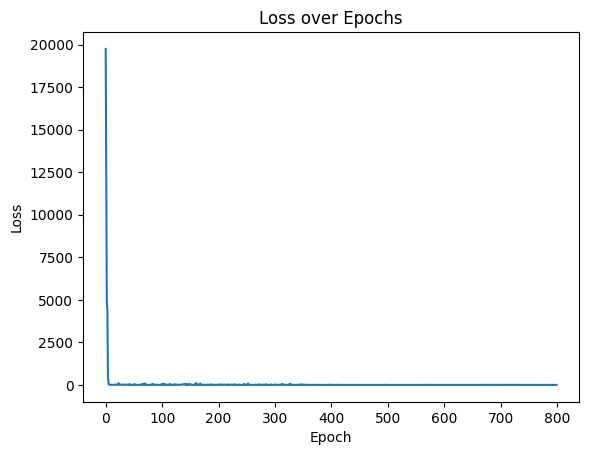

In [30]:
plt.plot(loss_list)

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [31]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index):
    actual_np = actual[index]
    pred_np = pred[index]


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, 'r+', label='predicted')

    if args['direction']:
        plt.title("Temperature to Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectrum to Temperature")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

In [32]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for temp_batch, spec_batch in test_loader:
        pred = model(inputs)
        loss = criterion(pred, actual)
        total_loss += loss.item() * len(X_batch)
        n_samples += len(X_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(pred.numpy(), actual.numpy(), 0) 

average_loss = total_loss/n_samples
print(f"average loss: {average_loss}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1 and 66x30)